# Chưa chỉnh tham số


📈 Learning Curve cho Decision Tree - Year_1


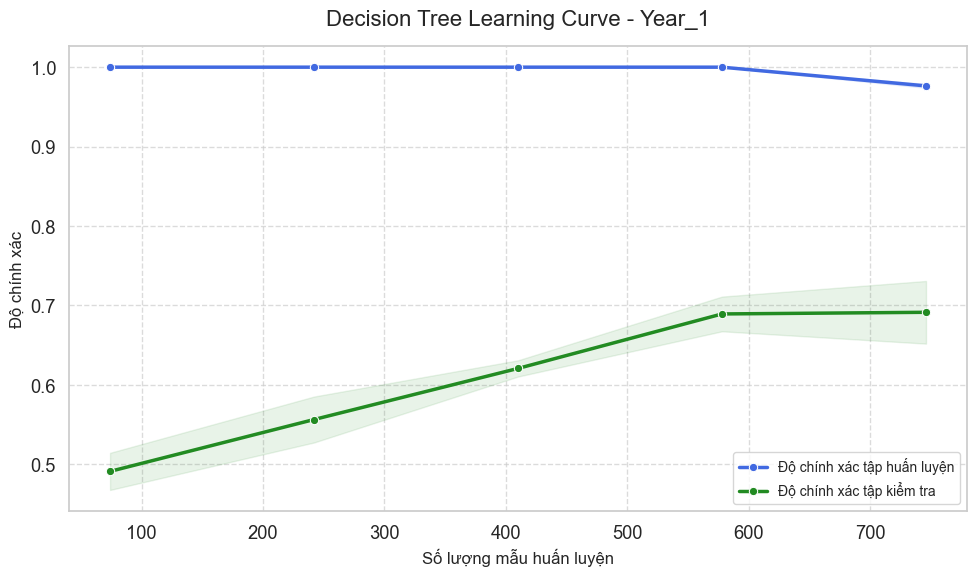


📈 Learning Curve cho SVM - Year_2


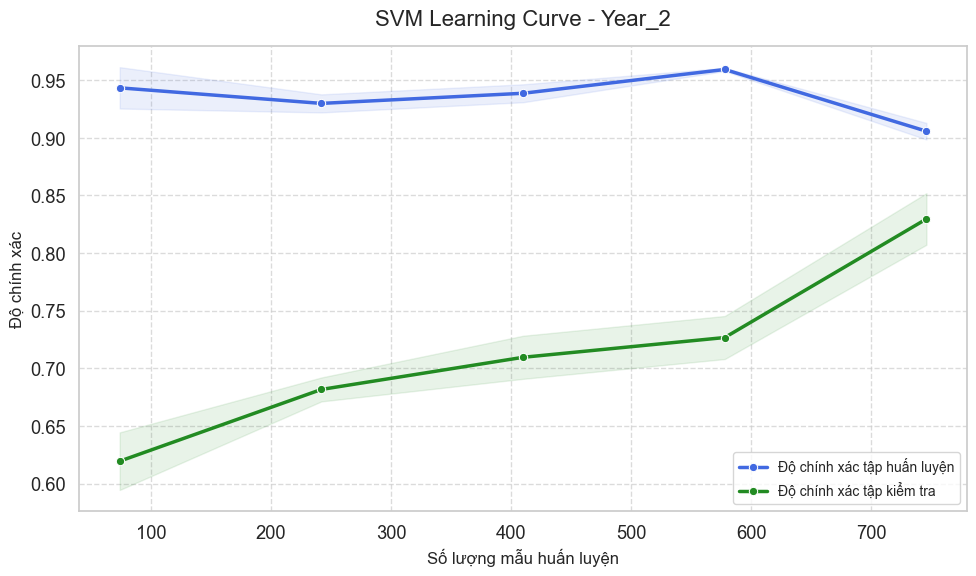


📈 Learning Curve cho SVM - Year_3


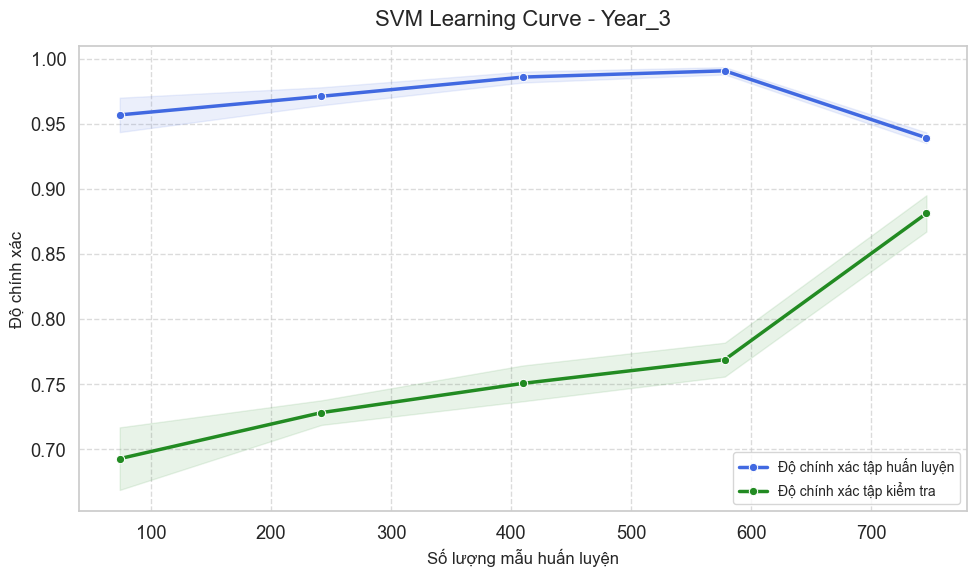


📈 Learning Curve cho Logistic Regression - Year_4


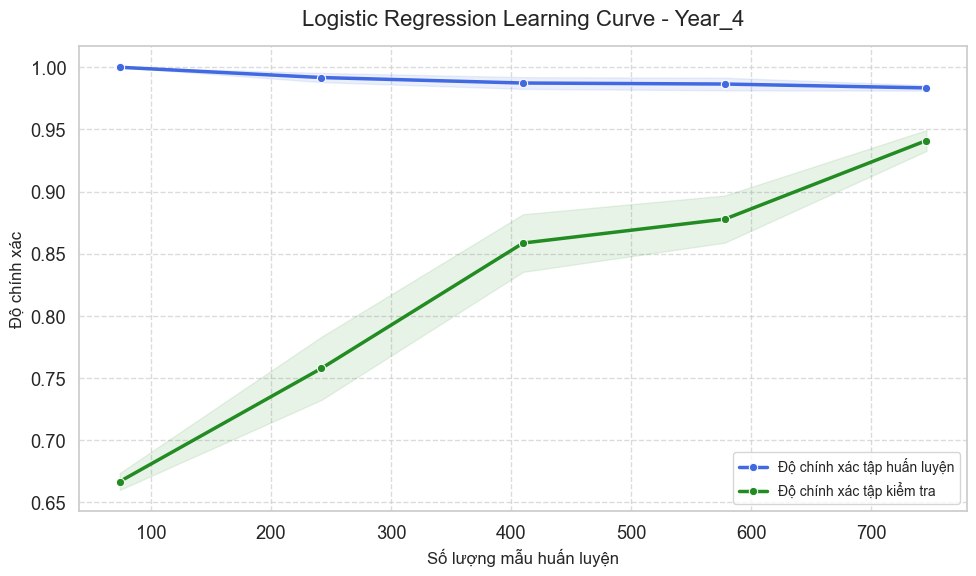


📊 Kết quả so sánh mô hình - Year_1:
   Năm          Thuật toán  Train Accuracy  Test Accuracy  Chênh lệch
Year_1       Decision Tree        0.973966       0.692857    0.281109
Year_1                 SVM        0.788668       0.628571    0.160096
Year_1                 KNN        0.753446       0.639286    0.114160
Year_1 Logistic Regression        0.698315       0.596429    0.101887
Year_1         Naive Bayes        0.666156       0.592857    0.073299
✅ Mô hình tốt nhất: Decision Tree với Accuracy test = 0.6929

📊 Kết quả so sánh mô hình - Year_2:
   Năm          Thuật toán  Train Accuracy  Test Accuracy  Chênh lệch
Year_2       Decision Tree        0.973966       0.750000    0.223966
Year_2                 KNN        0.793262       0.703571    0.089690
Year_2                 SVM        0.894334       0.821429    0.072905
Year_2         Naive Bayes        0.765697       0.721429    0.044268
Year_2 Logistic Regression        0.834609       0.792857    0.041752
✅ Mô hình tốt nhất: SVM v

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

# Set Seaborn style for beautiful plots
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# --- Tiền xử lý riêng ---
def pre_standard_zero(numeric_columns):
    return ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('scaler', StandardScaler())
        ]), numeric_columns)
    ])

def pre_standard_median(numeric_columns):
    return ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_columns)
    ])

def pre_median_only(numeric_columns):
    return ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median'))
        ]), numeric_columns)
    ])

def pre_mean_only(numeric_columns):
    return ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean'))
        ]), numeric_columns)
    ])

# --- Hàm vẽ Learning Curve với Seaborn ---
def plot_learning_curve(model, title, X, y, preprocessor, cv, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5)):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', SelectKBest(score_func=f_classif, k='all')),
        ('classifier', model)
    ])
    train_sizes, train_scores, val_scores = learning_curve(
        pipeline, X, y, cv=cv, train_sizes=train_sizes, scoring=scoring, n_jobs=-1
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.title(title, fontsize=16, pad=15)
    plt.xlabel("Số lượng mẫu huấn luyện", fontsize=12)
    plt.ylabel("Độ chính xác", fontsize=12)
    
    # Use Seaborn's lineplot for training and validation scores
    sns.lineplot(x=train_sizes, y=train_scores_mean, label="Độ chính xác tập huấn luyện", 
                 color="royalblue", linewidth=2.5, marker="o")
    sns.lineplot(x=train_sizes, y=val_scores_mean, label="Độ chính xác tập kiểm tra", 
                 color="forestgreen", linewidth=2.5, marker="o")
    
    # Add shaded areas for standard deviation
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="royalblue")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.1, color="forestgreen")
    
    plt.legend(loc="best", fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# --- Cấu hình mô hình KHÔNG dùng GridSearch ---
model_configs = {
    'SVM': {
        'model': SVC(),
        'preprocessing': pre_standard_zero
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'preprocessing': pre_standard_median
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'preprocessing': pre_mean_only
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'preprocessing': pre_median_only
    },
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000),
        'preprocessing': pre_standard_zero
    }
}

# --- Danh sách file ---
files = [
    ('Year_1_Results_num.xlsx', 'Year_1'),
    ('Year_2_Results_num.xlsx', 'Year_2'),
    ('Year_3_Results_num.xlsx', 'Year_3'),
    ('Year_4_Results_num.xlsx', 'Year_4')
]

# --- Kết quả từng năm ---
results_by_year = {}

# --- Huấn luyện ---
for path, year in files:
    df = pd.read_excel(path)
    X = df.drop(columns=['Xếp loại', 'Mã Sinh Viên'])
    y = df['Xếp loại']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    year_results = []

    for model_name, cfg in model_configs.items():
        preprocessor = cfg['preprocessing'](num_cols)
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('feature_selection', SelectKBest(score_func=f_classif, k='all')),
            ('classifier', cfg['model'])
        ])

        # Huấn luyện không cần GridSearch
        pipeline.fit(X_train, y_train)
        best_model = pipeline

        train_acc = accuracy_score(y_train, best_model.predict(X_train))
        test_acc = accuracy_score(y_test, best_model.predict(X_test))
        gap = train_acc - test_acc

        year_results.append({
            'Năm': year,
            'Thuật toán': model_name,
            'Train Accuracy': train_acc,
            'Test Accuracy': test_acc,
            'Chênh lệch': gap
        })

    # Lưu kết quả
    results_by_year[year] = year_results

    # Vẽ learning curve cho mô hình tốt nhất
    best_model_info = max(year_results, key=lambda x: x['Test Accuracy'])
    best_name = best_model_info['Thuật toán']
    best_cfg = model_configs[best_name]
    print(f"\n📈 Learning Curve cho {best_name} - {year}")
    plot_learning_curve(best_cfg['model'], f"{best_name} Learning Curve - {year}", X, y, best_cfg['preprocessing'](num_cols), cv)

# --- In kết quả từng năm ---
for year, results in results_by_year.items():
    df_result = pd.DataFrame(results).sort_values(by='Chênh lệch', ascending=False)
    print(f"\n📊 Kết quả so sánh mô hình - {year}:")
    print(df_result.to_string(index=False))
    best = max(results, key=lambda x: x['Test Accuracy'])
    print(f"✅ Mô hình tốt nhất: {best['Thuật toán']} với Accuracy test = {best['Test Accuracy']:.4f}")

# --- Tổng hợp kết quả ---
final_summary = [max(results, key=lambda x: x['Test Accuracy']) for results in results_by_year.values()]
df_summary = pd.DataFrame(final_summary)
print("\n📌 Tổng hợp mô hình tốt nhất theo từng năm:")
print(df_summary.to_string(index=False))

# có chỉnh tham số

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

# --- Tạo thư mục lưu mô hình ---
os.makedirs("saved_models", exist_ok=True)

# --- Hàm tiền xử lý ---
def pre_standard_zero(numeric_columns):
    return ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('scaler', StandardScaler())
        ]), numeric_columns)
    ])

def pre_standard_median(numeric_columns):
    return ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_columns)
    ])

def pre_median_only(numeric_columns):
    return ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median'))
        ]), numeric_columns)
    ])

def pre_mean_only(numeric_columns):
    return ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean'))
        ]), numeric_columns)
    ])

# --- Hàm vẽ Learning Curve ---
def plot_learning_curve(model, title, X, y, preprocessor, cv, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5)):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', SelectKBest(score_func=f_classif, k='all')),
        ('classifier', model)
    ])
    train_sizes, train_scores, val_scores = learning_curve(
        pipeline, X, y, cv=cv, train_sizes=train_sizes, scoring=scoring, n_jobs=-1
    )
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Accuracy')
    plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation Accuracy')
    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Cấu hình mô hình ---
model_configs = {
    'SVM': {
        'model': SVC(),
        'params': {
            'classifier__C': [0.01, 0.1, 1],
            'classifier__gamma': [0.001, 0.01],
            'classifier__kernel': ['rbf']
        },
        'preprocessing': pre_standard_zero  # ❗ Cần chuẩn hóa dữ liệu cho SVM
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'classifier__n_neighbors': [3, 5],
            'classifier__weights': ['uniform', 'distance']
        },
        'preprocessing': pre_standard_median  # ❗ Cần chuẩn hóa do dựa vào khoảng cách
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {},
        'preprocessing': pre_mean_only  # ✔️ Không cần chuẩn hóa, dùng giá trị trung bình
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'classifier__criterion': ['gini', 'entropy'],
            'classifier__max_depth': [3, 5, 10, 15, None],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 5],
            'classifier__ccp_alpha': [0.0, 0.005, 0.01, 0.02]
        },
        'preprocessing': pre_standard_zero  # ✔️ Không nhạy với scale, chỉ cần xử lý thiếu
    },
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'classifier__C': [0.1, 1, 10],
            'classifier__solver': ['liblinear', 'lbfgs']
        },
        'preprocessing': pre_standard_zero  # ✔️ Cần chuẩn hóa; 0 hợp lý cho dữ liệu rời rạc
    }
}


# --- Danh sách file ---
files = [
    ('Year_1_Results_num.xlsx', 'Year_1'),
    ('Year_2_Results_num.xlsx', 'Year_2'),
    ('Year_3_Results_num.xlsx', 'Year_3'),
    ('Year_4_Results_num.xlsx', 'Year_4')
]

# --- Kết quả từng năm ---
results_by_year = {}

# --- Huấn luyện mô hình ---
for path, year in files:
    df = pd.read_excel(path)
    X = df.drop(columns=['Xếp loại', 'Mã Sinh Viên'])
    y = df['Xếp loại']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    year_results = []

    for model_name, cfg in model_configs.items():
        preprocessor = cfg['preprocessing'](num_cols)
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('feature_selection', SelectKBest(score_func=f_classif, k='all')),
            ('classifier', cfg['model'])
        ])

        if cfg['params']:
            grid = GridSearchCV(pipeline, cfg['params'], cv=cv, scoring='accuracy', n_jobs=-1)
            grid.fit(X_train, y_train)
            best_model = grid.best_estimator_
        else:
            pipeline.fit(X_train, y_train)
            best_model = pipeline

        train_acc = accuracy_score(y_train, best_model.predict(X_train))
        test_acc = accuracy_score(y_test, best_model.predict(X_test))
        gap = train_acc - test_acc

        year_results.append({
            'Năm': year,
            'Thuật toán': model_name,
            'Train Accuracy': train_acc,
            'Test Accuracy': test_acc,
            'Chênh lệch': gap
        })

    results_by_year[year] = year_results

    # Vẽ learning curve cho mô hình tốt nhất
    best_model_info = max(year_results, key=lambda x: x['Test Accuracy'])
    best_name = best_model_info['Thuật toán']
    best_cfg = model_configs[best_name]
    print(f"\n📈 Learning Curve cho {best_name} - {year}")
    plot_learning_curve(best_cfg['model'], f"{best_name} Learning Curve - {year}", X, y, best_cfg['preprocessing'](num_cols), cv)

    # Lưu mô hình tốt nhất
    # model_filename = f"saved_models/best_model_{year}_{best_name.replace(' ', '_')}.pkl"
    # joblib.dump(best_model, model_filename)
    # print(f"💾 Đã lưu mô hình tốt nhất cho {year}: {model_filename}")

# --- In kết quả từng năm ---
for year, results in results_by_year.items():
    df_result = pd.DataFrame(results).sort_values(by='Chênh lệch', ascending=False)
    print(f"\n📊 Kết quả so sánh mô hình - {year}:")
    print(df_result.to_string(index=False))
    best = max(results, key=lambda x: x['Test Accuracy'])
    print(f"✅ Mô hình tốt nhất: {best['Thuật toán']} với Accuracy test = {best['Test Accuracy']:.4f}")

# --- Tổng hợp kết quả ---
final_summary = [max(results, key=lambda x: x['Test Accuracy']) for results in results_by_year.values()]
df_summary = pd.DataFrame(final_summary)
print("\n📌 Tổng hợp mô hình tốt nhất theo từng năm:")
print(df_summary.to_string(index=False))


# Dữ liệu chữ

In [1]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')

# Dữ liệu theo năm
files_uploaded = [
    ('./Year_1_results.xlsx', 'Year_1'),
    ('./Year_2_results.xlsx', 'Year_2'),
    ('./Year_3_results.xlsx', 'Year_3'),
    ('./Year_4_results.xlsx', 'Year_4')
]

# Chuẩn hóa điểm chữ
valid_grades = ['A', 'B', 'C', 'D', 'E', 'F']
def clean_grade(val):
    try:
        val = str(val).strip().upper()
        return val if val in valid_grades else 'F'
    except:
        return 'F'

# Hàm pipeline theo thuật toán
def build_pipeline(model_name, config, feature_cols):
    if model_name in ['SVM', 'Logistic Regression', 'KNN']:
        imputer_strategy = 'most_frequent'
    else:
        imputer_strategy = 'constant'
        
    preprocessor = ColumnTransformer([
        ('ordinal', Pipeline([
            ('imputer', SimpleImputer(strategy=imputer_strategy)),
            ('encoder', OrdinalEncoder(categories=[['F', 'E', 'D', 'C', 'B', 'A']] * len(feature_cols),
                                       handle_unknown='use_encoded_value', unknown_value=-1))
        ]), feature_cols)
    ])

    steps = [('preprocessor', preprocessor)]
    if config['scaler']:
        steps.append(('scaler', config['scaler']))
    steps.append(('classifier', config['model']))
    return Pipeline(steps)

# Cấu hình chuẩn (năm 3, 4)
model_configs = {
    'SVM': {
        'model': SVC(probability=True),
        'params': {
            'classifier__C': [0.1, 1, 10],
            'classifier__gamma': ['scale', 0.01, 0.1],
            'classifier__kernel': ['rbf']
        },
        'scaler': StandardScaler()
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'classifier__n_neighbors': [3, 5, 7, 9, 11],
            'classifier__weights': ['uniform', 'distance'],
            'classifier__p': [1, 2]
        },
        'scaler': StandardScaler()
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'classifier__criterion': ['gini', 'entropy'],
            'classifier__max_depth': [3, 5, 10],
            'classifier__min_samples_leaf': [2, 4, 6],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__ccp_alpha': [0.0, 0.005, 0.01, 0.02]
        },
        'scaler': None
    },
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'classifier__C': [0.01, 0.1, 1, 10, 100],
            'classifier__solver': ['liblinear', 'lbfgs', 'saga'],
            'classifier__penalty': ['l2']
        },
        'scaler': StandardScaler()
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {},
        'scaler': None
    }
}

# Cấu hình tối ưu riêng cho Year_1 và Year_2
model_configs_custom = {
    'SVM': {
        'model': SVC(probability=True),
        'params': {
            'classifier__C': [0.01, 0.05, 0.1, 0.5],  # thêm giá trị nhỏ hơn để tránh overfitting
            'classifier__gamma': ['scale', 0.01, 0.005],  # thêm gamma nhỏ hơn để điều chỉnh kernel
            'classifier__kernel': ['rbf']
        },
        'scaler': StandardScaler()
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'classifier__n_neighbors': [11, 13, 15, 17],  # tăng n_neighbors để làm mượt quyết định
            'classifier__weights': ['uniform'],           # chuyển về uniform để giảm ảnh hưởng của điểm gần
            'classifier__p': [2]                          # dùng khoảng cách Euclidean đơn giản, ổn định
        },
        'scaler': StandardScaler()
    },
'Decision Tree': {
    'model': DecisionTreeClassifier(random_state=42),
    'params': {
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [3, 4, 5, 6],  # thêm độ sâu 6 nếu dữ liệu không quá nhiều
        'classifier__min_samples_leaf': [5, 8, 10],  # tăng leaf size
        'classifier__min_samples_split': [10, 15, 20],  # tăng split threshold
        'classifier__ccp_alpha': [0.005, 0.01, 0.02, 0.05]  # thêm giá trị thấp hơn để kiểm soát pruning linh hoạt
    },
    'scaler': None
},

'Logistic Regression': {
    'model': LogisticRegression(max_iter=2000),
    'params': {
        'classifier__C': [0.001, 0.005, 0.01, 0.05, 0.1],  # thêm C = 0.1 nếu regularization quá mạnh
        'classifier__solver': ['liblinear', 'saga'],
        'classifier__penalty': ['l1', 'l2', 'elasticnet'],  # thử elasticnet để kết hợp L1 + L2
        'classifier__l1_ratio': [0.2, 0.5, 0.8]  # nếu dùng elasticnet → cần l1_ratio
    },
    'scaler': StandardScaler()
},

    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {}, 
        'scaler': None
    }
}


# Lưu kết quả
results_by_year = {}

for file_path, year in files_uploaded:
    df = pd.read_excel(file_path)
    X = df.drop(columns=['Mã Sinh Viên', 'Xếp loại'])
    y = df['Xếp loại']

    X = X.applymap(clean_grade)

    # Chia dữ liệu theo StratifiedShuffleSplit
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    for train_idx, test_idx in splitter.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    feature_cols = X.columns
    year_results = []

    # Chọn cấu hình phù hợp
    config_set = model_configs_custom if year in ['Year_1', 'Year_2'] else model_configs

    for model_name, config in config_set.items():
        pipeline = build_pipeline(model_name, config, feature_cols)

        if config['params']:
            grid = GridSearchCV(pipeline, config['params'], cv=5, n_jobs=-1)
            grid.fit(X_train, y_train)
            best_model = grid.best_estimator_
        else:
            best_model = pipeline.fit(X_train, y_train)

        train_acc = accuracy_score(y_train, best_model.predict(X_train))
        test_acc = accuracy_score(y_test, best_model.predict(X_test))
        gap = train_acc - test_acc

        year_results.append({
            'Năm': year,
            'Thuật toán': model_name,
            'Train Accuracy': round(train_acc, 4),
            'Test Accuracy': round(test_acc, 4),
            'Chênh lệch': round(gap, 4)
        })

    results_by_year[year] = year_results

# Tổng hợp mô hình tốt nhất mỗi năm
final_summary = [max(results, key=lambda x: x['Test Accuracy']) for results in results_by_year.values()]
df_summary = pd.DataFrame(final_summary)

print("\n📌 Tổng hợp mô hình tốt nhất theo từng năm:")
print(df_summary.to_string(index=False))



📌 Tổng hợp mô hình tốt nhất theo từng năm:
   Năm          Thuật toán  Train Accuracy  Test Accuracy  Chênh lệch
Year_1                 SVM          0.7443         0.6714      0.0728
Year_2                 SVM          0.8591         0.8464      0.0127
Year_3                 SVM          0.9433         0.8964      0.0469
Year_4 Logistic Regression          0.9862         0.9571      0.0291


In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Set Seaborn style for beautiful plots
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Dữ liệu theo năm
files_uploaded = [
    ('./Year_1_results.xlsx', 'Year_1'),
    ('./Year_2_results.xlsx', 'Year_2'),
    ('./Year_3_results.xlsx', 'Year_3'),
    ('./Year_4_results.xlsx', 'Year_4')
]

# Chuẩn hóa điểm chữ
valid_grades = ['A', 'B', 'C', 'D', 'F']
def clean_grade(val):
    try:
        val = str(val).strip().upper()
        return val if val in valid_grades else 'F'
    except:
        return 'F'

# Hàm pipeline theo thuật toán
def build_pipeline(model_name, config, feature_cols):
    if model_name in ['SVM', 'Logistic Regression', 'KNN']:
        imputer_strategy = 'most_frequent'
    else:
        imputer_strategy = 'constant'
        
    preprocessor = ColumnTransformer([
        ('ordinal', Pipeline([
            ('imputer', SimpleImputer(strategy=imputer_strategy)),
            ('encoder', OrdinalEncoder(categories=[['F', 'D', 'C', 'B', 'A']] * len(feature_cols),
                                       handle_unknown='use_encoded_value', unknown_value=-1))
        ]), feature_cols)
    ])

    steps = [('preprocessor', preprocessor)]
    if config['scaler']:
        steps.append(('scaler', config['scaler']))
    steps.append(('classifier', config['model']))
    return Pipeline(steps)

# Hàm vẽ learning curve với Seaborn
def plot_learning_curve(estimator, title, X, y, preprocessor, cv, train_sizes=np.linspace(0.1, 1.0, 5)):
    X_preprocessed = preprocessor.fit_transform(X)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X_preprocessed, y, cv=cv, n_jobs=-1, train_sizes=train_sizes, scoring='accuracy'
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.title(title, fontsize=16, pad=15)
    plt.xlabel("Số lượng mẫu huấn luyện", fontsize=12)
    plt.ylabel("Độ chính xác (Accuracy)", fontsize=12)
    
    # Use Seaborn's lineplot for training and cross-validation scores
    sns.lineplot(x=train_sizes, y=train_scores_mean, label="Độ chính xác tập huấn luyện", 
                 color="royalblue", linewidth=2.5, marker="o")
    sns.lineplot(x=train_sizes, y=test_scores_mean, label="Độ chính xác tập kiểm tra", 
                 color="forestgreen", linewidth=2.5, marker="o")
    
    # Add shaded areas for standard deviation
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="royalblue")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="forestgreen")
    
    plt.legend(loc="best", fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Cấu hình chuẩn (năm 3, 4)
model_configs = {
    'SVM': {
        'model': SVC(probability=True),
        'params': {
            'classifier__C': [0.1, 1, 10],
            'classifier__gamma': ['scale', 0.01, 0.1],
            'classifier__kernel': ['rbf']
        },
        'scaler': StandardScaler(),
        'preprocessing': lambda cols: ColumnTransformer([
            ('ordinal', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OrdinalEncoder(categories=[['F', 'D', 'C', 'B', 'A']] * len(cols),
                                           handle_unknown='use_encoded_value', unknown_value=-1))
            ]), cols)
        ])
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'classifier__n_neighbors': [3, 5, 7, 9, 11],
            'classifier__weights': ['uniform', 'distance'],
            'classifier__p': [1, 2]
        },
        'scaler': StandardScaler(),
        'preprocessing': lambda cols: ColumnTransformer([
            ('ordinal', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OrdinalEncoder(categories=[['F', 'D', 'C', 'B', 'A']] * len(cols),
                                           handle_unknown='use_encoded_value', unknown_value=-1))
            ]), cols)
        ])
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'classifier__criterion': ['gini', 'entropy'],
            'classifier__max_depth': [3, 5, 10],
            'classifier__min_samples_leaf': [2, 4, 6],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__ccp_alpha': [0.0, 0.005, 0.01, 0.02]
        },
        'scaler': None,
        'preprocessing': lambda cols: ColumnTransformer([
            ('ordinal', Pipeline([
                ('imputer', SimpleImputer(strategy='constant')),
                ('encoder', OrdinalEncoder(categories=[['F', 'D', 'C', 'B', 'A']] * len(cols),
                                           handle_unknown='use_encoded_value', unknown_value=-1))
            ]), cols)
        ])
    },
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'classifier__C': [0.01, 0.1, 1, 10, 100],
            'classifier__solver': ['liblinear', 'lbfgs', 'saga'],
            'classifier__penalty': ['l2']
        },
        'scaler': StandardScaler(),
        'preprocessing': lambda cols: ColumnTransformer([
            ('ordinal', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OrdinalEncoder(categories=[['F', 'D', 'C', 'B', 'A']] * len(cols),
                                           handle_unknown='use_encoded_value', unknown_value=-1))
            ]), cols)
        ])
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {},
        'scaler': None,
        'preprocessing': lambda cols: ColumnTransformer([
            ('ordinal', Pipeline([
                ('imputer', SimpleImputer(strategy='constant')),
                ('encoder', OrdinalEncoder(categories=[['F', 'D', 'C', 'B', 'A']] * len(cols),
                                           handle_unknown='use_encoded_value', unknown_value=-1))
            ]), cols)
        ])
    }
}

# Cấu hình tối ưu riêng cho Year_1 và Year_2
model_configs_custom = {
    'SVM': {
        'model': SVC(probability=True),
        'params': {
            'classifier__C': [0.01, 0.05, 0.1, 0.5],
            'classifier__gamma': ['scale', 0.01, 0.005],
            'classifier__kernel': ['rbf']
        },
        'scaler': StandardScaler(),
        'preprocessing': lambda cols: ColumnTransformer([
            ('ordinal', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OrdinalEncoder(categories=[['F', 'D', 'C', 'B', 'A']] * len(cols),
                                           handle_unknown='use_encoded_value', unknown_value=-1))
            ]), cols)
        ])
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'classifier__n_neighbors': [11, 13, 15, 17],
            'classifier__weights': ['uniform'],
            'classifier__p': [2]
        },
        'scaler': StandardScaler(),
        'preprocessing': lambda cols: ColumnTransformer([
            ('ordinal', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OrdinalEncoder(categories=[['F', 'D', 'C', 'B', 'A']] * len(cols),
                                           handle_unknown='use_encoded_value', unknown_value=-1))
            ]), cols)
        ])
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'classifier__criterion': ['gini', 'entropy'],
            'classifier__max_depth': [3, 4, 5, 6],
            'classifier__min_samples_leaf': [5, 8, 10],
            'classifier__min_samples_split': [10, 15, 20],
            'classifier__ccp_alpha': [0.005, 0.01, 0.02, 0.05]
        },
        'scaler': None,
        'preprocessing': lambda cols: ColumnTransformer([
            ('ordinal', Pipeline([
                ('imputer', SimpleImputer(strategy='constant')),
                ('encoder', OrdinalEncoder(categories=[['F', 'D', 'C', 'B', 'A']] * len(cols),
                                           handle_unknown='use_encoded_value', unknown_value=-1))
            ]), cols)
        ])
    },
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=2000),
        'params': {
            'classifier__C': [0.001, 0.005, 0.01, 0.05, 0.1],
            'classifier__solver': ['liblinear', 'saga'],
            'classifier__penalty': ['l1', 'l2', 'elasticnet'],
            'classifier__l1_ratio': [0.2, 0.5, 0.8]
        },
        'scaler': StandardScaler(),
        'preprocessing': lambda cols: ColumnTransformer([
            ('ordinal', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OrdinalEncoder(categories=[['F', 'D', 'C', 'B', 'A']] * len(cols),
                                           handle_unknown='use_encoded_value', unknown_value=-1))
            ]), cols)
        ])
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {},
        'scaler': None,
        'preprocessing': lambda cols: ColumnTransformer([
            ('ordinal', Pipeline([
                ('imputer', SimpleImputer(strategy='constant')),
                ('encoder', OrdinalEncoder(categories=[['F', 'D', 'C', 'B', 'A']] * len(cols),
                                           handle_unknown='use_encoded_value', unknown_value=-1))
            ]), cols)
        ])
    }
}

# Lưu kết quả
results_by_year = {}

for file_path, year in files_uploaded:
    df = pd.read_excel(file_path)
    X = df.drop(columns=['Mã Sinh Viên', 'Xếp loại'])
    y = df['Xếp loại']

    X = X.applymap(clean_grade)

    # Chia dữ liệu theo StratifiedShuffleSplit
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    for train_idx, test_idx in splitter.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    feature_cols = X.columns
    year_results = []

    # Chọn cấu hình phù hợp
    config_set = model_configs_custom if year in ['Year_1', 'Year_2'] else model_configs

    best_test_acc = -1
    best_model = None
    best_name = None

    for model_name, config in config_set.items():
        pipeline = build_pipeline(model_name, config, feature_cols)

        if config['params']:
            grid = GridSearchCV(pipeline, config['params'], cv=5, n_jobs=-1)
            grid.fit(X_train, y_train)
            model = grid.best_estimator_
        else:
            model = pipeline.fit(X_train, y_train)

        train_acc = accuracy_score(y_train, model.predict(X_train))
        test_acc = accuracy_score(y_test, model.predict(X_test))
        gap = train_acc - test_acc

        year_results.append({
            'Năm': year,
            'Thuật toán': model_name,
            'Train Accuracy': round(train_acc, 4),
            'Test Accuracy': round(test_acc, 4),
            'Chênh lệch': round(gap, 4)
        })

        # Lưu lại mô hình tốt nhất
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_model = model
            best_name = model_name

        # # Báo cáo classification_report
        # y_pred = model.predict(X_test)
        # print(f"\n📋 Classification Report cho {model_name} - {year}:\n")
        # print(classification_report(y_test, y_pred, digits=4))

    results_by_year[year] = year_results
    # Lưu mô hình tốt nhất
    model_filename = f"saved_models/best_model_{year}_{best_name.replace(' ', '_')}.pkl"
    joblib.dump(best_model, model_filename)
    print(f"💾 Đã lưu mô hình tốt nhất cho {year}: {model_filename}")

# Tổng hợp mô hình tốt nhất mỗi năm
final_summary = [max(results, key=lambda x: x['Test Accuracy']) for results in results_by_year.values()]
df_summary = pd.DataFrame(final_summary)

print("\n📌 Tổng hợp mô hình tốt nhất theo từng năm:")
print(df_summary.to_string(index=False))


📋 Classification Report cho SVM - Year_1:

                          precision    recall  f1-score   support

                    Giỏi     0.6087    0.7887    0.6871        71
                     Khá     0.7278    0.8582    0.7877       134
Ra trường không đúng hạn     1.0000    0.0370    0.0714        27
              Trung Bình     0.0000    0.0000    0.0000         7
                Xuất Sắc     0.6667    0.1333    0.2222        15

                accuracy                         0.6850       254
               macro avg     0.6006    0.3635    0.3537       254
            weighted avg     0.6998    0.6850    0.6283       254


📋 Classification Report cho KNN - Year_1:

                          precision    recall  f1-score   support

                    Giỏi     0.5556    0.7042    0.6211        71
                     Khá     0.7013    0.8060    0.7500       134
Ra trường không đúng hạn     0.5000    0.0370    0.0690        27
              Trung Bình     0.0000    0.0000    0

In [31]:
import joblib

# Load pipeline đã lưu
pipeline = joblib.load("saved_models/best_model_Year_1_SVM.pkl")

# In ra các bước trong pipeline
print(pipeline)
# print(type(pipeline))



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ordinal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(categories=[['F',
                                                                                               'D',
                                                                                               'C',
                                                                                               'B',
                                                                                               'A'],
                                                                                              ['F',
                                        

In [38]:
import joblib
import pandas as pd

# Tải mô hình
model = joblib.load('saved_models/best_model_Year_1_SVM.pkl')

# Danh sách đầy đủ các cột mà mô hình yêu cầu
required_columns = [
    'Kinh Tế Chính Trị Mác- Lênin', 'Xác Suất Thống Kê', 'Bảo Trì Hệ Thống',
    'Giải Tích 1', 'Đại Số Tuyến Tính', 'Tin Học Đại Cương',
    'Triết Học Mác- Lênin', 'Nhập Môn Ngành Cntt', 'Giải Tích 2',
    'Kỹ Thuật Lập Trình', 'Chủ Nghĩa Xã Hội Khoa Học', 'Vật Lý Điện Từ'
]

# Tạo dữ liệu mẫu (giá trị có thể thay đổi tùy bạn muốn test gì)
sample_data = ['A', 'B', 'C', 'A', 'B', 'C', 'D', 'A', 'B', 'C', 'A', 'B']

# Tạo DataFrame
input_df = pd.DataFrame([sample_data], columns=required_columns)

# Dự đoán
try:
    prediction = model.predict(input_df)
    print("Kết quả dự đoán:", prediction)
except Exception as e:
    print("Lỗi khi dự đoán:", str(e))


Kết quả dự đoán: ['Khá']


In [23]:
import pickle
import numpy as np

# Đường dẫn đến file .pkl
model_file = 'saved_models/best_model_Year_1_SVM.pkl'

# Tải file .pkl và kiểm tra nội dung
with open(model_file, 'rb') as file:
    model = pickle.load(file)

# In kiểu của model
print("Kiểu của model:", type(model))
print("Nội dung của model:", model)

Kiểu của model: <class 'numpy.ndarray'>
Nội dung của model: ['Tin Học Đại Cương' 'Bảo Trì Hệ Thống' 'Đại Số Tuyến Tính'
 'Nhập Môn Ngành Cntt' 'Triết Học Mác- Lênin' 'Vật Lý Điện Từ'
 'Giải Tích 1' 'Kinh Tế Chính Trị Mác- Lênin' 'Kỹ Thuật Lập Trình'
 'Giải Tích 2' 'Xác Suất Thống Kê' 'Chủ Nghĩa Xã Hội Khoa Học']
